In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.misc import comb
from sklearn.model_selection import train_test_split , KFold, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pdb
from sklearn.metrics import roc_auc_score , make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import NuestroArbol as ourTree
import random
from scipy.stats import randint as sp_randint
from time import time
import collections

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


## Cargar datos 

In [2]:
X_comp = pd.read_csv('X_competencia.csv')
X = pd.read_csv('X.csv',index_col="index")
y = pd.read_csv('y.csv',index_col="index")

In [3]:
#partimos los datos en desarrollo(87%) y holdout(13%). 
X_desarrollo , X_holout ,y_desarrollo, y_holdout = train_test_split(X, y['output'],
                                                                    test_size=0.13,random_state=0,stratify=y['output'])
#pase los kfold aca arriba ya que se usan en varios lugares.
#evaluar si esta bueno que siempre se usen los mismos folds
kfold = StratifiedKFold(n_splits=5)
kfold.get_n_splits(X_desarrollo,y_desarrollo)


5

# Ejercicio 4

### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----



# 4.1

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

### Arboles

In [15]:
params=range(1,21) # depths

dic={}
for d in params:
    ROC_AUC_train=[]
    ROC_AUC_val=[]
    
    for train, test  in kfold.split(X_desarrollo,y_desarrollo):
        X_train, X_val = X_desarrollo.iloc[train], X_desarrollo.iloc[test]
        y_train, y_val = y_desarrollo.iloc[train], y_desarrollo.iloc[test]

        model=DecisionTreeClassifier(max_depth=d,criterion='entropy')
        model.fit(X_train,y_train)

        ROC_AUC_train.append(roc_auc_score(y_train,model.predict(X_train)))
        ROC_AUC_val.append(roc_auc_score(y_val,model.predict(X_val)))
        
    tsm=np.mean(ROC_AUC_train)
    tse=np.std(ROC_AUC_train)
    vsm=np.mean(ROC_AUC_val)
    vse=np.std(ROC_AUC_val)
    
    dic[d]={"train_score_mean":tsm,"train_score_err":tse,"val_score_mean":vsm,"val_score_err":vse}

df=pd.DataFrame(dic).T
df.reindex(params)

,train_score_err,train_score_mean,val_score_err,val_score_mean
1,0.009820,0.708113,0.031808,0.655714
2,0.013465,0.714335,0.015673,0.663084
3,0.018214,0.789064,0.056431,0.679687
4,0.012501,0.840352,0.026974,0.659504
5,0.008941,0.917444,0.048227,0.693967
6,0.012479,0.959011,0.043831,0.686398
7,0.004723,0.986262,0.050380,0.686157
8,0.002759,0.994103,0.033897,0.684182
9,0.000000,1.000000,0.041421,0.690671
10,0.000000,1.000000,0.037279,0.703153


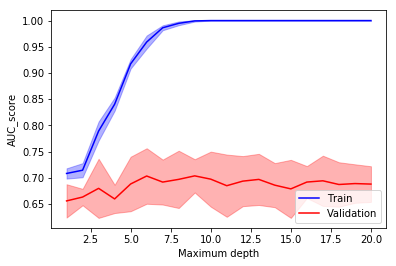

In [5]:
plt.plot(df.index,df.train_score_mean,color="b",label="Train")
plt.fill_between(df.index, df.train_score_mean - df.train_score_err,
                 df.train_score_mean + df.train_score_err, alpha=0.3,color="b")

plt.plot(df.index,df.val_score_mean,color="r",label="Validation")
plt.fill_between(df.index, df.val_score_mean - df.val_score_err,
                 df.val_score_mean + df.val_score_err, alpha=0.3,color="r")

plt.xlabel("Maximum depth")
plt.ylabel("AUC_score")
plt.legend()
plt.show()

### SVC

In [11]:
# Tomo el mejor gamma y el mejor kernel encontrado mediante RandomSearch y GridSearch

#params=[0.01,0.1,1,10,100,1000] # Cs
params=[10,25,50,100,250,500,1000]
#params=[50,60,70,80,90,100,110,120,130,140,150]

dic={}
for c in params:
    ROC_AUC_train=[]
    ROC_AUC_val=[]
    
    for train, test  in kfold.split(X_desarrollo,y_desarrollo):
        X_train, X_val = X_desarrollo.iloc[train], X_desarrollo.iloc[test]
        y_train, y_val = y_desarrollo.iloc[train], y_desarrollo.iloc[test]

        model=SVC(C=c,kernel="rbf",gamma=0.00707269)
        model.fit(X_train,y_train)

        ROC_AUC_train.append(roc_auc_score(y_train,model.predict(X_train)))
        ROC_AUC_val.append(roc_auc_score(y_val,model.predict(X_val)))
        
    tsm=np.mean(ROC_AUC_train)
    tse=np.std(ROC_AUC_train)
    vsm=np.mean(ROC_AUC_val)
    vse=np.std(ROC_AUC_val)
    
    dic[c]={"train_score_mean":tsm,"train_score_err":tse,"val_score_mean":vsm,"val_score_err":vse}

df=pd.DataFrame(dic).T
df.reindex(params)

,train_score_err,train_score_mean,val_score_err,val_score_mean
10,0.0,1.0,0.038927,0.767768
25,0.0,1.0,0.038927,0.767768
50,0.0,1.0,0.038927,0.767768
100,0.0,1.0,0.038927,0.767768
250,0.0,1.0,0.038927,0.767768
500,0.0,1.0,0.038927,0.767768
1000,0.0,1.0,0.038927,0.767768


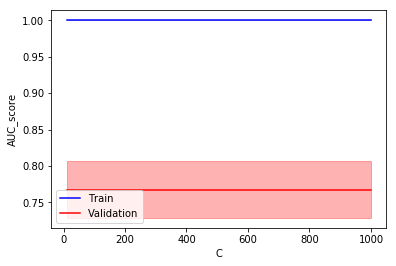

In [12]:
plt.plot(df.index,df.train_score_mean,color="b",label="Train")
plt.fill_between(df.index, df.train_score_mean - df.train_score_err,
                 df.train_score_mean + df.train_score_err, alpha=0.3,color="b")

plt.plot(df.index,df.val_score_mean,color="r",label="Validation")
plt.fill_between(df.index, df.val_score_mean - df.val_score_err,
                 df.val_score_mean + df.val_score_err, alpha=0.3,color="r")

plt.xlabel("C")
plt.ylabel("AUC_score")
plt.legend()
plt.show()

## :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-

# 4.2

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [16]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5),scoring='roc_auc'):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.3,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.3, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### Árboles

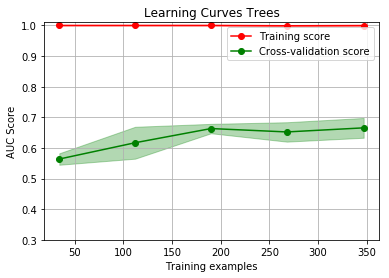

In [19]:
title = "Learning Curves Trees"

kfold = StratifiedKFold(n_splits=5)
kfold.get_n_splits(X_desarrollo,y_desarrollo)

estimator = DecisionTreeClassifier(max_depth=10)
plot_learning_curve(estimator, title, X_desarrollo, y_desarrollo, ylim=(0.3, 1.01), cv=kfold, n_jobs=-1)

plt.show()

### SVC

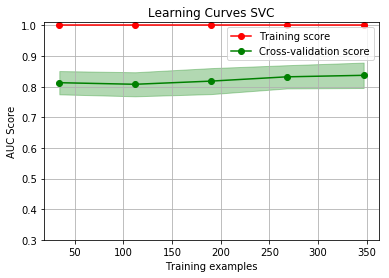

In [20]:
title = "Learning Curves SVC"

kfold = StratifiedKFold(n_splits=5)
kfold.get_n_splits(X_desarrollo,y_desarrollo)

estimator = SVC(C=50,kernel="rbf",gamma=0.00707269)
plot_learning_curve(estimator, title, X_desarrollo, y_desarrollo, ylim=(0.3, 1.01), cv=kfold, n_jobs=-1)

plt.show()

## :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-

# 4.3

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

### GridSearch

In [ ]:
param_grid = {'max_features': ['sqrt', 'log2']+range(0,201,20)[1:],
              'max_depth' : range(4,20),
              'criterion' :['gini', 'entropy']}

model=RandomForestClassifier(n_estimators=200,random_state=42,n_jobs=-1)
RFgrid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring='roc_auc',n_jobs=-1)
RFgrid.fit(X_desarrollo, y_desarrollo);

RFgrid.best_estimator_

### Curva de max_features

In [161]:
params=range(0,20)[1:]

dic={}
for c in params:
    ROC_AUC_train=[]
    ROC_AUC_val=[]
    
    for train, test in kfold.split(X_desarrollo,y_desarrollo):
        X_train, X_val = X_desarrollo.iloc[train], X_desarrollo.iloc[test]
        y_train, y_val = y_desarrollo.iloc[train], y_desarrollo.iloc[test]

#        model=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy', max_depth=11,max_features=c, 
#                                     max_leaf_nodes=None,min_impurity_decrease=0.0,min_impurity_split=None,
#                                     min_samples_leaf=1, min_samples_split=2,min_weight_fraction_leaf=0.0,n_estimators=200, 
#                                     n_jobs=-1,oob_score=False,random_state=42,verbose=0, warm_start=False)
        model=RFgrid.best_estimator_
        model.max_features=c
        model.fit(X_train,y_train)

        ROC_AUC_train.append(roc_auc_score(y_train,model.predict(X_train)))
        ROC_AUC_val.append(roc_auc_score(y_val,model.predict(X_val)))
        
    tsm=np.mean(ROC_AUC_train)
    tse=np.std(ROC_AUC_train)
    vsm=np.mean(ROC_AUC_val)
    vse=np.std(ROC_AUC_val)
    
    dic[c]={"train_score_mean":tsm,"train_score_err":tse,"val_score_mean":vsm,"val_score_err":vse}

df=pd.DataFrame(dic).T
df.reindex(params);

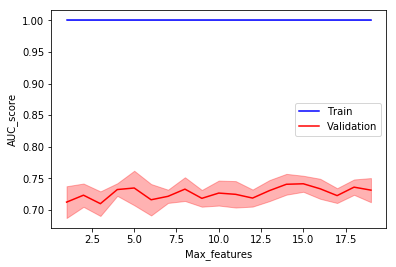

In [162]:
plt.plot(df.index,df.train_score_mean,color="b",label="Train")
plt.fill_between(df.index, df.train_score_mean - df.train_score_err,
                 df.train_score_mean + df.train_score_err, alpha=0.3,color="b")

plt.plot(df.index,df.val_score_mean,color="r",label="Validation")
plt.fill_between(df.index, df.val_score_mean - df.val_score_err,
                 df.val_score_mean + df.val_score_err, alpha=0.3,color="r")

plt.xlabel("Max_features")
plt.ylabel("AUC_score")
plt.legend()
plt.show()

In [287]:
#df

### Curva de aprendizaje

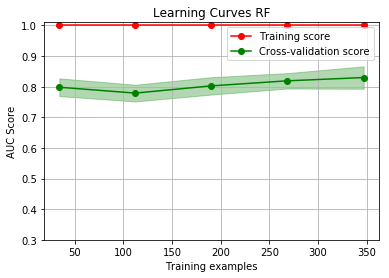

In [166]:
#model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy', max_depth=11,max_features=15, 
#                               max_leaf_nodes=None,min_impurity_decrease=0.0,min_impurity_split=None,min_samples_leaf=1, 
#                               min_samples_split=2,min_weight_fraction_leaf=0.0,n_estimators=200, n_jobs=-1,
#                               oob_score=False,random_state=42,verbose=0, warm_start=False)

model=RFgrid.best_estimator_

title = "Learning Curves RF"
plot_learning_curve(model, title, X_desarrollo, y_desarrollo, ylim=(0.3, 1.01), cv=kfold, n_jobs=-1)

plt.show()

## :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-

# Ejercicio Extra

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

EJERCICIO EXTRA: Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).

In [169]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [288]:
param_grid = {'max_features': ['sqrt', 'log2']+range(0,201,20)[1:],
              'max_depth' : sp.stats.randint(2,20), 
              'learning_rate': np.logspace(-3,0,num=50),
              'n_estimators':sp.stats.randint(10,200)}

model=GradientBoostingClassifier(random_state = 0)

GBCgrid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=kfold, scoring='roc_auc',n_jobs=-1)
GBCgrid.fit(X_desarrollo, y_desarrollo);

GBCgrid.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.039069399370546168, loss='deviance',
              max_depth=12, max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=175,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

### Curva de aprendizaje

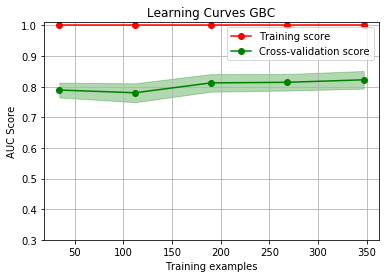

In [289]:
model=GBCgrid.best_estimator_

title = "Learning Curves GBC"
plot_learning_curve(model, title, X_desarrollo, y_desarrollo, ylim=(0.3, 1.01), cv=kfold, n_jobs=-1)

plt.show()

In [304]:
model=GBCgrid.best_estimator_
model.fit(X_desarrollo,y_desarrollo)
roc_auc_score(y_holdout,model.predict(X_holout))

0.661904761904762

In [303]:
model=RFgrid.best_estimator_
model.fit(X_desarrollo,y_desarrollo)
roc_auc_score(y_holdout,model.predict(X_holout))

0.75714285714285712